In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import truncnorm
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'scripts'))
from methods import test_by_ons, test_by_ftrl_barrier, test_by_optftrl_barrier, test_by_co96, test_by_oj23

# Synthetic Datasets

In [16]:
def sample_truncated_normal(mu, sigma, size):
    # Truncate to [0, 1]
    a, b = (0 - mu) / sigma, (1 - mu) / sigma
    return truncnorm.rvs(a, b, loc=mu, scale=sigma, size=size)

def generate_data(n=10000, seed=33):
    np.random.seed(seed)
    data = {}

    # Scenario 1: Uniform distributions with substantial overlap
    xt1 = np.random.uniform(0.2, 0.8, size=n)
    yt1 = np.random.uniform(0.3, 0.9, size=n)
    data['uniform distributions'] = (xt1, yt1)

    # Scenario 2: Truncated normals with substantial overlap
    xt3 = sample_truncated_normal(mu=0.5, sigma=0.15, size=n)
    yt3 = sample_truncated_normal(mu=0.6, sigma=0.15, size=n)
    data['truncated normal distributions'] = (xt3, yt3)


    return data


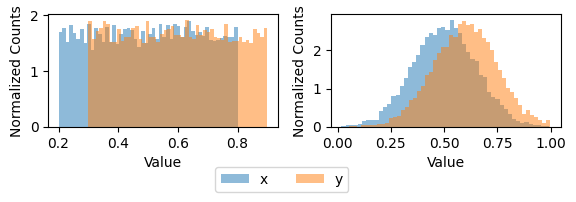

In [17]:
# Plot distributions
def plot_distributions_2x2_with_shared_legend(data_dict):
    fig, axes = plt.subplots(1, 2, figsize=(6, 2))
    axes = axes.flatten()

    for idx, (key, (x, y)) in enumerate(data_dict.items()):
        ax = axes[idx]
        ax.hist(x, bins=50, alpha=0.5, label='x', density=True)
        ax.hist(y, bins=50, alpha=0.5, label='y', density=True)
        #ax.set_title(f'{key}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Normalized Counts')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])  
    fig.savefig('./tmp.png', dpi=300, bbox_inches='tight')

    plt.show()

data = generate_data()
plot_distributions_2x2_with_shared_legend(data)


# Implement Experiments

In [4]:
def run_all_methods(xt, yt, n_trials=20):
    
    alpha = 0.05

    methods = {
        'OJ23': lambda xt, yt: test_by_oj23(xt, yt, alpha),
        'CO96': lambda xt, yt: test_by_co96(xt, yt, alpha),
        'OFTRL+Barrier': lambda xt, yt: test_by_optftrl_barrier(xt, yt, alpha),
        'FTRL+Barrier': lambda xt, yt: test_by_ftrl_barrier(xt, yt, alpha),
        'ONS': lambda xt, yt: test_by_ons(xt, yt, alpha)      
    }

    results = {}

    for name, func in methods.items():
        run_times = []
        stopping_times = []

        for i in range(n_trials):
            # shuffle xt, yt
            seq1 = np.squeeze( xt[i,:] )
            seq2 = np.squeeze( yt[i,:] )       
            real_time, length = func(seq1, seq2)
            run_times.extend(real_time)
            stopping_times.append(length)

        results[name] = {
            'n_trials': n_trials,
            'avg_time': np.mean(run_times),
            'std_time': np.std(run_times),
            'stopping_times': stopping_times

        }

    return results


In [5]:
def plot_rejection_time(results, filename=None):
    num_methods = len(results)
    colors = sns.color_palette("colorblind", num_methods)

    fig, ax = plt.subplots(figsize=(6.5, 0.7 + 0.7 * num_methods))

    y_step = 1.1
    y_offsets = np.arange(num_methods) * y_step
    all_data = [res['stopping_times'] for res in results.values()]
    xlim_max = max([max(d) if len(d) > 0 else 0 for d in all_data]) + 2
    x_text_right = xlim_max + 0.5

    for i, (method, res) in enumerate(results.items()):
        data = np.array(res['stopping_times'], dtype=float)
        data = data[np.isfinite(data)]

        if len(data) > 1:
            if np.std(data) < 1e-6:
                center = np.mean(data)
                xs = np.linspace(center - 1, center + 1, 200)
                ys = np.exp(-0.5 * ((xs - center) / 0.2)**2)
            else:
                kde = gaussian_kde(data)
                xs = np.linspace(0, data.max() + 0.3 * abs(data.max()), 300)
                ys = kde(xs)

            ys = ys / ys.max() * 0.8
            ax.fill_between(xs, y_offsets[i] + ys, y_offsets[i], color=colors[i], alpha=0.4)

            median = np.median(data)
            median_height = np.interp(median, xs, ys)
            ax.vlines(x=median, ymin=y_offsets[i],
                      ymax=y_offsets[i] + median_height,
                      color=colors[i], linestyle="--", linewidth=1)

        ax.text(x_text_right*1.35, y_offsets[i], method,
                va='center', ha='left', fontsize=14)

    ax.set_xlim(left=0, right=x_text_right*1.4)
    kde_height = 0.8
    top_buffer = 0.2
    
    ax.set_ylim(-0.2, y_offsets[-1] + kde_height + top_buffer)

    ax.set_yticks([])
    ax.set_xlabel("Rejection Time", fontsize=12) 
    for spine in ax.spines.values():
        spine.set_linewidth(1)  
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='x', labelsize=12, which='major', length=5,  width=1)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



=== Average Iteration Runtime (ms) ===
OJ23: avg = 0.600817, std = 0.185730
CO96: avg = 0.381144, std = 0.108137
OFTRL+Barrier: avg = 0.002280, std = 0.000487
FTRL+Barrier: avg = 0.001694, std = 0.000487
ONS: avg = 0.001146, std = 0.000391


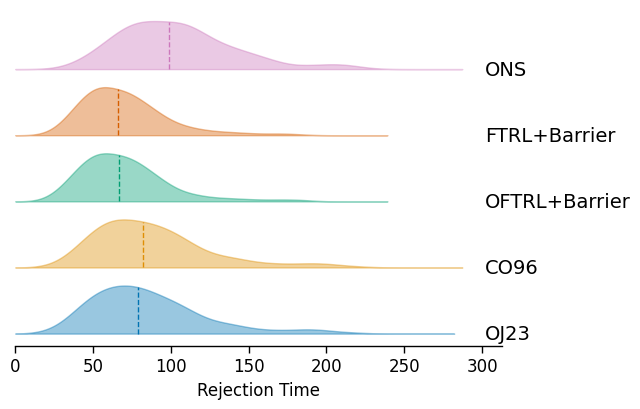

In [6]:
# Scenario 1: Uniform distributions with substantial overlap
np.random.seed(100)
t     = 10000
iters = 300

xt1 = np.random.uniform(0.2, 0.8, size=(iters, t)  )
yt1 = np.random.uniform(0.3, 0.9, size=(iters, t)  )

results = run_all_methods(xt1, yt1, n_trials=300)

print("=== Average Iteration Runtime (ms) ===")
for method, res in results.items():
    print(f"{method}: avg = {res['avg_time']:.6f}, std = {res['std_time']:.6f}")

plot_rejection_time(results, filename="./plot_results/uniform_high_overlap_dist.png")

=== Average Iteration Runtime (ms) ===
OJ23: avg = 0.604081, std = 0.162663
CO96: avg = 0.410580, std = 0.077488
OFTRL+Barrier: avg = 0.002285, std = 0.000498
FTRL+Barrier: avg = 0.001719, std = 0.000490
ONS: avg = 0.001148, std = 0.000387


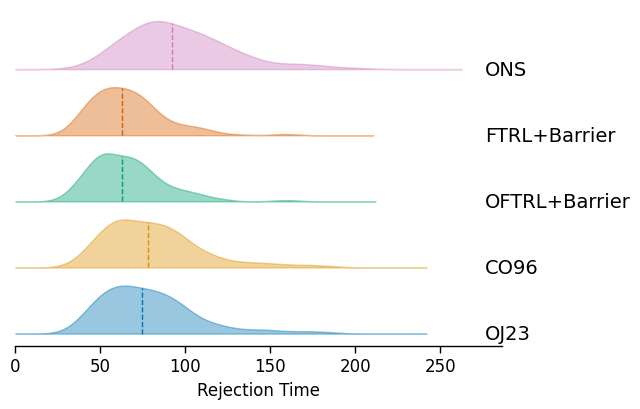

In [8]:
# Scenario 2: Truncated normals with substantial overlap
np.random.seed(100)

xt2 = sample_truncated_normal(mu=0.5, sigma=0.15, size=(iters, t) )
yt2 = sample_truncated_normal(mu=0.6, sigma=0.15, size=(iters, t) )

results = run_all_methods(xt2, yt2, n_trials=300)
print("=== Average Iteration Runtime (ms) ===")
for method, res in results.items():
    print(f"{method}: avg = {res['avg_time']:.6f}, std = {res['std_time']:.6f}")

plot_rejection_time(results, filename="./plot_results/trunc_high_overlap_dist.png")

=== Average Iteration Runtime (ms) ===
OJ23: avg = 0.460956, std = 0.015715
CO96: avg = 0.429462, std = 0.003031
OFTRL+Barrier: avg = 0.002373, std = 0.000526
FTRL+Barrier: avg = 0.001762, std = 0.000461
ONS: avg = 0.001181, std = 0.000412


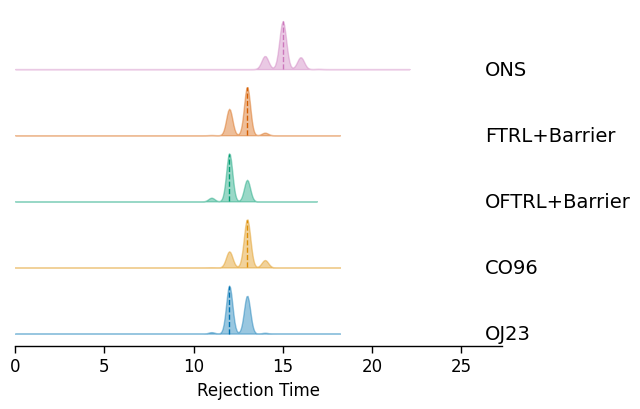

In [10]:
# Scenario 3: Uniform distributions with distjoint overlap
np.random.seed(100)
t     = 1500
iters = 300

xt3 = np.random.uniform(0.2, 0.4, size=(iters, t)  )
yt3 = np.random.uniform(0.7, 0.9, size=(iters, t)  )

results = run_all_methods(xt3, yt3, n_trials=300)

print("=== Average Iteration Runtime (ms) ===")
for method, res in results.items():
    print(f"{method}: avg = {res['avg_time']:.6f}, std = {res['std_time']:.6f}")

plot_rejection_time(results, filename="./plot_results/uniform_disjoint_dist.png")